# Visualizing Bitcoin Trust Networks

Below is a who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1.

Let's see if we can produce some meaningful insights by visualizing a snapshot of the network.


## Dataset statistics

* Nodes	5,881
* Edges	35,592
* Range of edge weight	-10 to +10
* Percentage of positive edges	89%

## Sampling

One month sample is used with a broad range of ratings.
## Visualization

Uses a multi-edged directed graph to display ratings.  Fruchterman Reingold force-directed algorithm was used for layout.


* Larger nodes have more reviews
* Green nodes are positively reviewed on average
* Red nodes are negatively reviewed on average
* Color intensity is degree of trust (positive or negative)
* Edges are directed
* Longer edges are more negative, shorter edges are more positive


## Data format

Weighted Signed Directed Bitcoin OTC web of trust network

http://snap.stanford.edu/data/soc-sign-bitcoinotc.html

Each line has one rating, sorted by time, with the following format:

SOURCE, TARGET, RATING, TIME

* SOURCE: node id of source, i.e., rater
* TARGET: node id of target, i.e., ratee
* RATING: the source's rating for the target, ranging from -10 to +10 in steps of 1
* TIME: the time of the rating, measured as seconds since Epoch. (This can be converted to human readable data easily as described here)

## Download Data and Parse

In [1]:
import os
import requests
import pandas as pd

url = 'https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz'
fname = os.path.basename(url)

if not os.path.isfile(fname):
    print(f"Downloading...\n{url}")
    r = requests.get(url, allow_redirects=True)
    open(fname, 'wb').write(r.content)
else:
    print(f"Already downloaded:\n{url}")
    
# parse the file
cols = ['source', 'target', 'rating', 'time']
df = pd.read_csv(fname, names=cols, header=None)
df['time'] = pd.to_datetime(df.time * 1e9)
df = df.set_index('time')
df.shape

Already downloaded:
https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz


(35592, 3)

## Subsampling

What's the distribution of values look like month-to-month? Can we subsample to visualize a reasonable number of nodes?

In [8]:
# ratings overview by month
df.resample('M').rating.value_counts().unstack().sample(5)

rating,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10
time,,,,,,,,,,,,,,,,,,,,
2013-01-31,59.0,1.0,NaN,NaN,NaN,10.0,2.0,4.0,6.0,15.0,457.0,147.0,76.0,40.0,27.0,10.0,4.0,15.0,2.0,21.0
2014-10-31,3.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,3.0,10.0,120.0,40.0,12.0,11.0,17.0,3.0,2.0,3.0,NaN,2.0
2012-10-31,134.0,1.0,2.0,1.0,NaN,10.0,NaN,18.0,1.0,19.0,609.0,146.0,57.0,26.0,26.0,9.0,7.0,1.0,3.0,18.0
2012-02-29,7.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,2.0,5.0,288.0,107.0,30.0,15.0,21.0,1.0,5.0,3.0,NaN,5.0
2016-01-31,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,17.0,13.0,NaN,4.0,4.0,1.0,1.0,NaN,NaN,NaN


In [9]:
# later adoption years have a broader range of values
# this month has a good spread of ratings
df_ = df.loc['2014-03']
print(f"Ratings: {len(df_)}")
df_.sample(10)

Ratings: 330


,source,target,rating
time,,,
2014-03-26 23:58:48.204959744,4244,4235,-5
2014-03-15 02:53:26.228549888,5460,4649,1
2014-03-15 06:24:29.530480128,5403,5422,1
2014-03-20 22:16:47.716380160,35,5468,1
2014-03-31 15:20:48.911369984,5484,5363,-10
2014-03-16 20:39:53.108669952,4291,3919,1
2014-03-14 02:17:13.370089984,1437,775,1
2014-03-13 20:31:22.824110080,2125,4833,2
2014-03-07 16:04:25.605910016,1565,905,-1


# NetworkX

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

https://networkx.github.io/

## Multiedged Directed Graph

A directed graph class that can store multiedges. Multiedges are multiple edges between two nodes. Each edge can hold optional data or attributes.

https://networkx.github.io/documentation/stable/reference/classes/multidigraph.html

In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import math

DG = nx.MultiDiGraph()
edges = [(t.source, t.target, float(t.rating)) for t in df_.itertuples()]
DG.add_weighted_edges_from(edges)

print(f"Nodes: {DG.number_of_nodes()}")
print(f"Edges: {DG.number_of_edges()}")

Nodes: 211
Edges: 330


# Visualization

* Node size: number of transactions / reviews
* Node color: average positivity or negativity of node's reviews
* Edge length: the mistrust of a single review, closer is more trusted
* Position: Fruchterman-Reingold force-directed algorithm

We expect trusted nodes to transact more with each other, appear larger, and have on average more positive reviews and thusshorter edges. These should cluster together.

Nodes with lower trust should appear smaller and have longer edges. With the force-directed algorithm, these should be pushed away from trusted clusters.

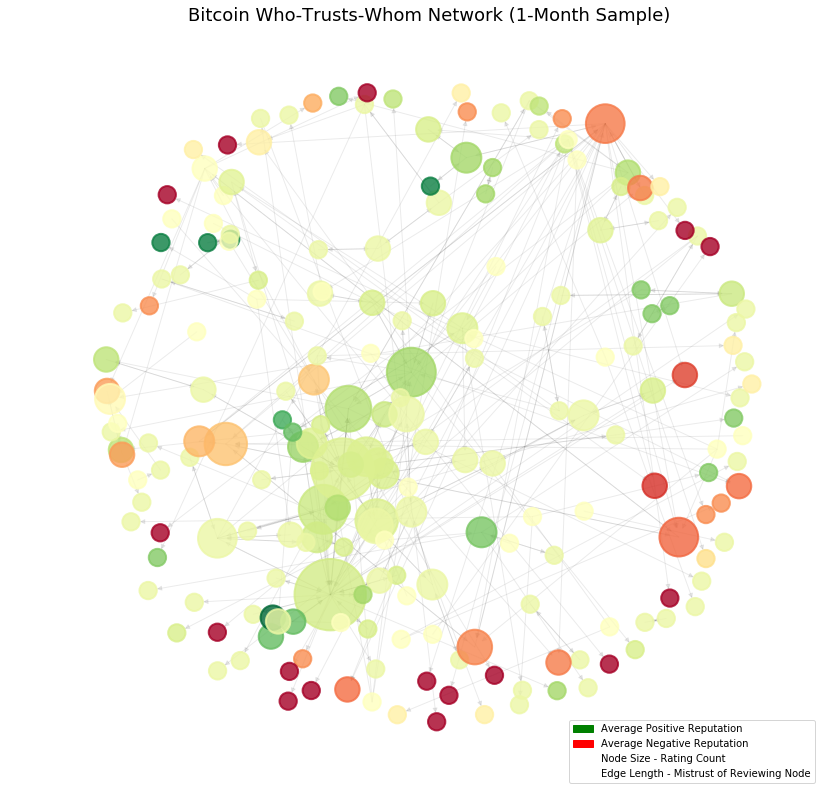

In [183]:
# build a lookup of review counts and average trust rating
review_counts = df_.groupby('target').rating.count()
average_reviews = df_.groupby('target').rating.mean()

def get_size(user_id, m=200, min=300):
    s = review_counts.get(user_id)
    if s is not None:
        return min * s
    else:
        return min

def get_color(user_id):
    s = average_reviews.get(user_id)
    if s is None:
        return 0.5
    # need a scaling function to translate -10-10 to 0.0-1.0 for colors maps
    return np.interp(s, (-10, 10), (0, 1))

plt.figure(figsize=(14, 14)) 
plt.title("Bitcoin Who-Trusts-Whom Network (1-Month Sample)", fontsize=18)

untrusted = mpatches.Patch(color='red', label='Average Negative Reputation')
trusted = mpatches.Patch(color='green', label='Average Positive Reputation')
size = mpatches.Patch(color='white', label='Node Size - Rating Count')
edges = mpatches.Patch(color='white', label='Edge Length - Mistrust of Reviewing Node')
plt.legend(handles=[trusted, untrusted, size, edges], loc='lower right')

pos = nx.spring_layout(DG, k=0.25)
sizes = [get_size(n) for n in DG]
colors = [get_color(n) for n in DG]

nc = nx.draw_networkx_nodes(
    DG, pos, nodelist=DG.nodes(), node_size=sizes, linewidths=2.0,
    node_color=colors, cmap=plt.cm.RdYlGn, alpha=0.8
)
ec = nx.draw_networkx_edges(DG, pos, arrows=True, alpha=0.08)
ax = plt.axis('off')
plt.show()

# Observations

* Larger nodes appear to cluster together as expected
* It seems with more ratings, there's less likelihood to maintain a high average rating
* Highly negatively rated nodes (dark red) appear to be pushed to the perimeter and away from positive / high transaction clusters
* A few nodes have consistently been negatively rated (large red)

## Areas to explore

* It would be interesting to see how this changes month-to-month and track nodes by id
* A better visualization might not have nodes overlapping, or use an algorithm for bundling edges as shown here: http://holoviews.org/user_guide/Network_Graphs.html

# References

* Stanford Network Analysis Project, [Bitcoin OTC trust weighted signed network](http://snap.stanford.edu/data/soc-sign-bitcoinotc.html)
* S. Kumar, F. Spezzano, V.S. Subrahmanian, C. Faloutsos. [Edge Weight Prediction in Weighted Signed Networks.](http://cs.stanford.edu/~srijan/pubs/wsn-icdm16.pdf) IEEE International Conference on Data Mining (ICDM), 2016.
* NetworkX Tutorial, [Multigraphs](https://networkx.github.io/documentation/stable/tutorial.html#multigraphs)
* Fruchterman, T. M. J., & Reingold, E. M. (1991). [Graph Drawing by Force-Directed Placement.](http://citeseer.ist.psu.edu/viewdoc/download;jsessionid=19A8857540E8C9C26397650BBACD5311?doi=10.1.1.13.8444&rep=rep1&type=pdf) Software: Practice and Experience, 21(11).
* HoloViews, [Creating interactive network graphs](http://holoviews.org/user_guide/Network_Graphs.html)